**Modulo 4 : Entrenamiento para Datos Tabulares**
* Instructor: [Juan Maniglia](https://juanmaniglia.github.io)

# Parte 4.2: Multiclases Clasificación con ROC y AUC

* **Binary Clasificación** - Clasificación entre dos posibilidades (positiva y negativa). Común en las pruebas médicas, si la persona tiene la enfermedad (positivo) o no (negativo).
* **Clasificación** - Clasificación entre más de 2. El conjunto de datos del iris (clasificación de 3 vías).
* **Regresión** - Predicción numérica. ¿Cuántos MPG obtiene un automóvil?.

En esta sesión de clase, veremos algunas visualizaciones para los tres.


Es importante evaluar el nivel de error en los resultados producidos por una red neuronal. En esta parte, veremos cómo evaluar el error para las redes neuronales de clasificación y regresión.

## Binary Clasificación y gráficos ROC 

La clasificación binaria ocurre cuando una red neuronal debe elegir entre dos opciones, que pueden ser verdadero/falso, sí/no, correcto/incorrecto o comprar/vender. Para ver cómo usar la clasificación binaria, consideraremos un sistema de clasificación para una compañía de tarjetas de crédito. Este sistema de clasificación debe decidir cómo responder a un nuevo cliente potencial. Este sistema "emitirá una tarjeta de crédito" o "rechazará una tarjeta de crédito".

Cuando solo tiene dos clases que puede considerar, la puntuación de la función objetivo es la cantidad de predicciones falsas positivas frente a la cantidad de falsos negativos. Los falsos negativos y los falsos positivos son tipos de errores y es importante comprender la diferencia. Para el ejemplo anterior, emitir una tarjeta de crédito sería lo positivo. Un falso positivo ocurre cuando se emite una tarjeta de crédito a alguien que se convertirá en un mal riesgo crediticio. Un falso negativo ocurre cuando se rechaza una tarjeta de crédito a alguien que habría sido un buen riesgo.

Debido a que solo existen dos opciones, podemos elegir el error que es el tipo de error más grave, un falso positivo o un falso negativo. Para la mayoría de los bancos que emiten tarjetas de crédito, un falso positivo es peor que un falso negativo. Rechazar a un titular de tarjeta de crédito potencialmente bueno es mejor que aceptar a un titular de tarjeta de crédito que haría que el banco realizara costosas actividades de cobro.
 

In [2]:
import pandas as pd

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/wcbreast_wdbc.csv",
    na_values=['NA','?'])

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 5)

display(df)

,id,diagnosis,mean_radius,mean_texture,mean_perimeter,...,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,...,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,...,0.18660,0.2416,0.1860,0.2750,0.08902
...,...,...,...,...,...,...,...,...,...,...,...
567,927241,M,20.60,29.33,140.10,...,0.86810,0.9387,0.2650,0.4087,0.12400
568,92751,B,7.76,24.54,47.92,...,0.06444,0.0000,0.0000,0.2871,0.07039


Las curvas ROC pueden ser un poco confusas. Sin embargo, son muy comunes. Es importante saber leerlos. Incluso su nombre es confuso. No te preocupes por su nombre, proviene de ingeniería eléctrica (EE).

La clasificación binaria es común en las pruebas médicas. A menudo desea diagnosticar si alguien tiene una enfermedad. Esto puede dar lugar a dos tipos de errores, conocidos como falsos positivos y falsos negativos:

* **Falso positivo**: su prueba (red neuronal) indicó que el paciente tenía la enfermedad; sin embargo, el paciente no tenía la enfermedad.
* **Falso Negativo** - Su prueba (red neuronal) indicó que el paciente no tenía la enfermedad; sin embargo, el paciente sí tenía la enfermedad.
* **Verdadero positivo**: su prueba (red neuronal) identificó correctamente que el paciente tenía la enfermedad.
* **Verdadero Negativo** - Su prueba (red neuronal) identificó correctamente que el paciente no tenía la enfermedad.

Los tipos de errores se pueden ver en la Figura 4.ETYP. 

**Figure 4.ETYP: Type of Error**
![Type of Error](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_4_errors.png "Type of Error")

Las redes neuronales clasifican en términos de probabilidad de que sea positivo. Sin embargo, ¿con qué probabilidad da un resultado positivo? ¿El corte es del 50%? 90%? El lugar donde establece este límite se denomina umbral. Todo lo que esté por encima del límite es positivo, todo lo que esté por debajo es negativo. Establecer este límite permite que el modelo sea más sensible o específico:

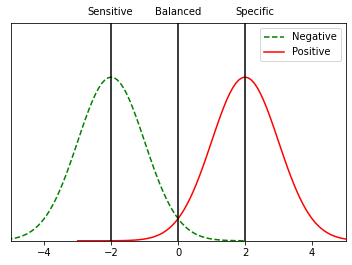

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu1 = -2
mu2 = 2
variance = 1
sigma = math.sqrt(variance)
x1 = np.linspace(mu1 - 5*sigma, mu1 + 4*sigma, 100)
x2 = np.linspace(mu2 - 5*sigma, mu2 + 4*sigma, 100)
plt.plot(x1, stats.norm.pdf(x1, mu1, sigma)/1,color="green", 
         linestyle='dashed')
plt.plot(x2, stats.norm.pdf(x2, mu2, sigma)/1,color="red")
plt.axvline(x=-2,color="black")
plt.axvline(x=0,color="black")
plt.axvline(x=+2,color="black")
plt.text(-2.7,0.55,"Sensitive")
plt.text(-0.7,0.55,"Balanced")
plt.text(1.7,0.55,"Specific")
plt.ylim([0,0.53])
plt.xlim([-5,5])
plt.legend(['Negative','Positive'])
plt.yticks([])
plt.show()

In [6]:
from scipy.stats import zscore

# Preparar datos: aplicar z-score a TODAS las columnas x
# Solo haga esto si no tiene categóricos (y está seguro de que
# quiero usar el z-score en todos los ámbitos)
x_columns = df.columns.drop('diagnosis').drop('id')
for col in x_columns:
    df[col] = zscore(df[col])

# Convertir a numpy - Regresión
x = df[x_columns].values
y = df['diagnosis'].map({'M':1,"B":0}).values # Binary clasificación

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot una matrix de confusión.
# cm es la matrix de confusión, names son los nombres de las clases.
def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot una ROC. pred - the predicciones, y - la salida esperada.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

### Ejemplo de gráfico de una curva ROC

El siguiente código demuestra cómo implementar un gráfico ROC

In [8]:
# Red neuronal de Clasificación
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Dividir en train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu',
                kernel_initializer='random_normal'))
model.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(1,activation='sigmoid',kernel_initializer='random_normal'))
model.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
    patience=5, verbose=1, mode='auto', restore_best_weights=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2,epochs=1000)


Epoch 1/1000
14/14 - 1s - loss: 0.6822 - accuracy: 0.8662 - val_loss: 0.6582 - val_accuracy: 0.9580 - 1s/epoch - 76ms/step
Epoch 2/1000
14/14 - 0s - loss: 0.6083 - accuracy: 0.9343 - val_loss: 0.5025 - val_accuracy: 0.9720 - 65ms/epoch - 5ms/step
Epoch 3/1000
14/14 - 0s - loss: 0.3826 - accuracy: 0.9413 - val_loss: 0.2066 - val_accuracy: 0.9720 - 63ms/epoch - 5ms/step
Epoch 4/1000
14/14 - 0s - loss: 0.1688 - accuracy: 0.9531 - val_loss: 0.0831 - val_accuracy: 0.9790 - 62ms/epoch - 4ms/step
Epoch 5/1000
14/14 - 0s - loss: 0.1006 - accuracy: 0.9695 - val_loss: 0.0583 - val_accuracy: 0.9790 - 68ms/epoch - 5ms/step
Epoch 6/1000
14/14 - 0s - loss: 0.0800 - accuracy: 0.9765 - val_loss: 0.0511 - val_accuracy: 0.9860 - 65ms/epoch - 5ms/step
Epoch 7/1000
14/14 - 0s - loss: 0.0698 - accuracy: 0.9789 - val_loss: 0.0521 - val_accuracy: 0.9860 - 61ms/epoch - 4ms/step
Epoch 8/1000
14/14 - 0s - loss: 0.0632 - accuracy: 0.9789 - val_loss: 0.0471 - val_accuracy: 0.9930 - 66ms/epoch - 5ms/step
Epoch 9/1

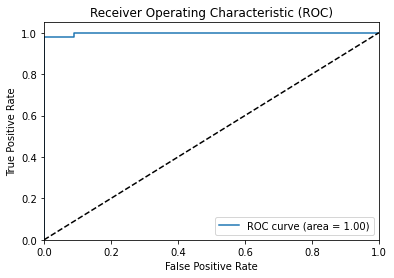

In [9]:
pred = model.predict(x_test)
plot_roc(pred,y_test)

### Métricas de error de clasificación multiclase

Si desea predecir más de un resultado, necesitará más de una neurona de salida. Debido a que una sola neurona puede predecir dos resultados, una red neuronal con dos neuronas de salida es algo rara. Si hay tres o más resultados, habrá tres o más neuronas de salida. Las siguientes secciones examinarán varias métricas para evaluar el error de clasificación. La siguiente red neuronal de clasificación se utilizará para evaluar.

In [10]:
import pandas as pd
from scipy.stats import zscore

# Leer el dataset
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generar dummies para 'job'
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generar dummies para 'area'
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Tratar Missing values en income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Estandarizar rangos
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convertir a numpy - Clasificación
x_columns = df.columns.drop('product').drop('id')
x = df[x_columns].values
dummies = pd.get_dummies(df['product']) # Clasificación
products = dummies.columns
y = dummies.values

In [11]:
# Red neuronal de Clasificación
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Dividir en train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu',
                kernel_initializer='random_normal'))
model.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(y.shape[1],activation='softmax',
                kernel_initializer='random_normal'))
model.compile(loss='categorical_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2,epochs=1000)


Epoch 1/1000
47/47 - 1s - loss: 1.5147 - accuracy: 0.3840 - val_loss: 1.1319 - val_accuracy: 0.4980 - 574ms/epoch - 12ms/step
Epoch 2/1000
47/47 - 0s - loss: 1.1213 - accuracy: 0.4787 - val_loss: 1.0621 - val_accuracy: 0.5100 - 158ms/epoch - 3ms/step
Epoch 3/1000
47/47 - 0s - loss: 1.0031 - accuracy: 0.5553 - val_loss: 0.9449 - val_accuracy: 0.6420 - 176ms/epoch - 4ms/step
Epoch 4/1000
47/47 - 0s - loss: 0.8700 - accuracy: 0.6553 - val_loss: 0.8572 - val_accuracy: 0.6840 - 167ms/epoch - 4ms/step
Epoch 5/1000
47/47 - 0s - loss: 0.8030 - accuracy: 0.6813 - val_loss: 0.8240 - val_accuracy: 0.6780 - 168ms/epoch - 4ms/step
Epoch 6/1000
47/47 - 0s - loss: 0.7758 - accuracy: 0.6907 - val_loss: 0.8104 - val_accuracy: 0.6760 - 168ms/epoch - 4ms/step
Epoch 7/1000
47/47 - 0s - loss: 0.7677 - accuracy: 0.6767 - val_loss: 0.7894 - val_accuracy: 0.6820 - 181ms/epoch - 4ms/step
Epoch 8/1000
47/47 - 0s - loss: 0.7350 - accuracy: 0.6933 - val_loss: 0.7839 - val_accuracy: 0.6840 - 176ms/epoch - 4ms/step

### Calcular la precisión de clasificación
 
La precisión es el número de filas donde la red neuronal predijo correctamente la clase objetivo. La precisión solo se usa para la clasificación, no para la regresión.

$$ precisión = \frac{c}{N} $$

Donde $c$ es el número correcto y $N$ es el tamaño del conjunto evaluado (entrenamiento o validación). Se desean números de mayor precisión.

Como acabamos de ver, por defecto, Keras devolverá el porcentaje de probabilidad para cada clase. Podemos cambiar estas probabilidades de predicción en el iris real predicho con **argmax**.

In [12]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) 
# probabilidades brutas a la clase elegida (probabilidad más alta)

Ahora que hemos predicho la flor real del iris, podemos calcular el porcentaje de precisión (cuántos se clasificaron correctamente).

In [13]:
from sklearn import metrics

y_compare = np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.708


### Calcular Log Loss en Clasificación

La precisión es como un examen final sin crédito parcial. Sin embargo, las redes neuronales pueden predecir una probabilidad de cada una de las clases objetivo. Las redes neuronales darán altas probabilidades a las predicciones que son más probables. La pérdida de registro es una métrica de error que penaliza la confianza en las respuestas incorrectas. Se desean valores de pérdida logarítmica más bajos.

El siguiente código muestra la salida de predict_proba:


In [14]:
from IPython.display import display

# No mostrar numpy en notación científica
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generar predicciones
pred = model.predict(x_test)

print("Numpy array de predicciones")
display(pred[0:5])

print("Como porcentaje de probabilidad")
print(pred[0]*100)

score = metrics.log_loss(y_test, pred)
print("Log loss score: {}".format(score))

# probabilidades brutas a la clase elegida (probabilidad más alta)
pred = np.argmax(pred,axis=1) 

Numpy array de predicciones


array([[0.    , 0.0926, 0.7774, 0.1291, 0.001 , 0.    , 0.    ],
       [0.    , 0.7306, 0.268 , 0.    , 0.0013, 0.    , 0.    ],
       [0.    , 0.7574, 0.2364, 0.0001, 0.006 , 0.0001, 0.    ],
       [0.    , 0.3321, 0.6581, 0.0064, 0.0033, 0.    , 0.    ],
       [0.    , 0.016 , 0.5375, 0.4464, 0.0001, 0.    , 0.    ]],
      dtype=float32)

Como porcentaje de probabilidad
[ 0.      9.2557 77.7405 12.9061  0.0974  0.0003  0.    ]
Log loss score: 0.7390038914233447


[Log loss](https://www.kaggle.com/wiki/LogarithmicLoss) se calcula de la siguiente manera:

$$ {log loss} = -\frac{1}{N}\sum_{i=1}^N {( {y}_i\log(\hat{y}_i) + (1 - {y}_i)\log(1 - \hat{y}_i))} $$


Debe usar esta ecuación solo como una función objetivo para las clasificaciones que tienen dos resultados. La variable y-hat es la predicción de la red neuronal y la variable y es la respuesta correcta conocida. En este caso, y siempre será 0 o 1. Los datos de entrenamiento no tienen probabilidades. La red neuronal lo clasifica en una clase (1) o en otra (0).

La variable N representa el número de elementos en el conjunto de entrenamiento el número de preguntas en la prueba. Dividimos por N porque este proceso es habitual para un promedio. También comenzamos la ecuación con un negativo porque la función logarítmica siempre es negativa en el dominio de 0 a 1. Esta negación permite minimizar un puntaje positivo para el entrenamiento.

Notarás que dos términos están separados por la suma (+). Cada uno contiene una función de registro. Debido a que y será 0 o 1, entonces uno de estos dos términos se cancelará en 0. Si y es 0, entonces el primer término se reducirá a 0. Si y es 1, entonces el segundo término será 0.

Si su predicción para la primera clase de una predicción de dos clases es y-hat, entonces su predicción para la segunda clase es 1 menos y-hat. Esencialmente, si su predicción para la clase A es del 70 % (0,7), entonces su predicción para la clase B es del 30 % (0,3). Su puntaje aumentará según el registro de su predicción para la clase correcta. Si la red neuronal hubiera predicho 1,0 para la clase A y la respuesta correcta fuera A, su puntaje aumentaría en log (1), que es 0. Para la pérdida de log, buscamos un puntaje bajo, por lo que una respuesta correcta da como resultado 0. Algunos de estos valores de registro para la estimación de probabilidad de una red neuronal para la clase correcta:

* -log(1.0) = 0
* -log(0.95) = 0.02
* -log(0.9) = 0.05
* -log(0.8) = 0.1
* -log(0.5) = 0.3
* -log(0.1) = 1
* -log(0.01) = 2
* -log(1.0e-12) = 12
* -log(0.0) = negative infinity

Como puede ver, dar una confianza baja a la respuesta correcta afecta más la puntuación. Debido a que log (0) es infinito negativo, normalmente imponemos un valor mínimo. Por supuesto, los valores de registro anteriores son para un solo elemento del conjunto de entrenamiento. Promediaremos los valores de registro para todo el conjunto de entrenamiento.

La función log es útil para penalizar las respuestas incorrectas. El siguiente código demuestra la utilidad de la función de registro:

C:\Users\jamr1\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


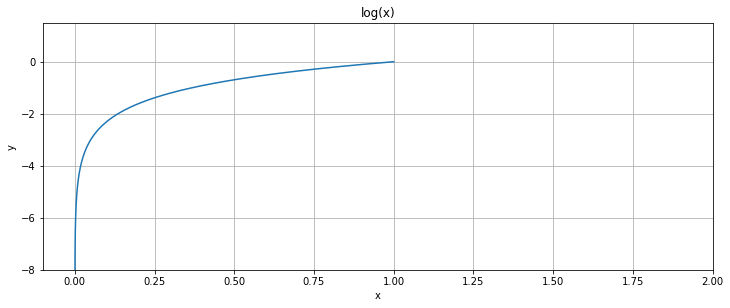

In [16]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange, sin, pi

#t = arange(1e-5, 5.0, 0.00001)
#t = arange(1.0, 5.0, 0.00001) # computer scientists
t = arange(0.0, 1.0, 0.00001)  # data     scientists

fig = figure(1,figsize=(12, 10))

ax1 = fig.add_subplot(211)
ax1.plot(t, np.log(t))
ax1.grid(True)
ax1.set_ylim((-8, 1.5))
ax1.set_xlim((-0.1, 2))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('log(x)')

show();

Matrix de confusión, sin normalizar
[[ 21   1   0   0   0   0   0]
 [  4 192  53   0   0   0   0]
 [  0  48 136   3   0   0   0]
 [  0   0   9   5   0   0   0]
 [  0   8   0   0   0   0   0]
 [ 10   7   0   0   0   0   0]
 [  3   0   0   0   0   0   0]]
Matrix de confusión normalizada
[[0.95 0.05 0.   0.   0.   0.   0.  ]
 [0.02 0.77 0.21 0.   0.   0.   0.  ]
 [0.   0.26 0.73 0.02 0.   0.   0.  ]
 [0.   0.   0.64 0.36 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.59 0.41 0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.  ]]


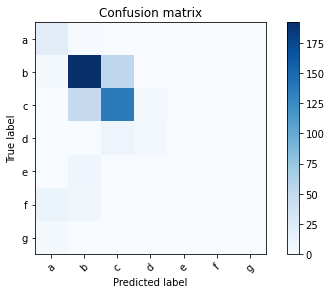

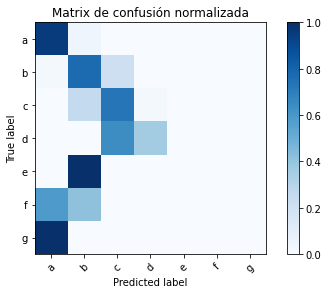

In [17]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Calcular matrix de confusión
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Matrix de confusión, sin normalizar')
print(cm)
plt.figure()
plot_confusion_matrix(cm, products)

# Normalizando la matrix de confusión por filas
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Matrix de confusión normalizada')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, 
        title='Matrix de confusión normalizada')

plt.show()